## Can I Run?

In this example we will use a quantum computer to solve a classical Machine Learning problem: Given a set of constraints, if there are too many of them, then what is the right combination such that Malai is able to go for a run.

For this example, we will take a look at 3 constraints:
- Is it raining outside? - If yes, then I can't run
- Is it cool outside? - If yes, then I can run
- Need to drop son in school? - If yes, then I can't run
- Time - I am an avid runner. I will run even if it is raining as long as it is between 5am and 7am

Now to Define the different constraints:
- If it rains (1), then malai will run only if the time is between 5am and 7am (1)
- If it does not rain (0), and the time is not between 5am and 7am (0), he will run only if he does not have to drop his son (0) and if it is cool (1)
- Finally, if it does not rain (0), but the time is between 5am and 7am (1), he will run.

In [1]:
def cir(rain, time, drop, temp):
    if rain:
        return time
    elif not(rain):
        if time:
            return time
        elif not(time) and drop:
            return time
        elif not(time) and not(drop) and temp:
            return temp
        else:
            return time

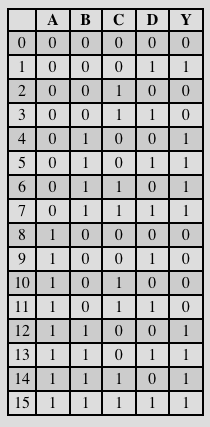

In [2]:
from IPython.display import Image
Image(filename='img.png')

First we start by importing all the DWave Packages and initialising the DWave solver.
We add the constraints that we discussed previously.

In [3]:
import dwavebinarycsp

csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

#Our constraints in this case are rain, temperature, drop and time.
csp.add_constraint(cir, ['rain', 'time', 'drop', 'temp'])

In [4]:
bqm = dwavebinarycsp.stitch(csp)

print('The BQM is')
bqm.quadratic

The BQM is


{('rain', 'drop'): 0.0,
 ('temp', 'drop'): 0.0,
 ('temp', 'rain'): 0.0,
 ('time', 'drop'): -2.6666668,
 ('time', 'rain'): -2.6666668,
 ('time', 'temp'): 2.6666668}

Running it on the DWave System

In [5]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler())

import time
start_time=time.time()
response = sampler.sample(bqm, num_reads=5000)
request_time=time.time()-start_time

print(f"Total Time Taken to get result: {round(request_time, 2)} sec")

Total Time Taken to get result: 4.44 sec


Getting the Answers

In [6]:
# total = 0
# for sample, energy, occurrences in response.data(['sample', 'energy', 'num_occurrences']):
#     total = total + occurrences
#     if energy == min_energy:
#         time = 'business hours' if sample['time'] else 'evenings'
#         location = 'office' if sample['location'] else 'home'
#         length = 'short' if sample['length'] else 'long'
#         mandatory = 'mandatory' if sample['mandatory'] else 'optional'
#         print("{}: During {} at {}, you can schedule a {} meeting that is {}".format(occurrences, time, location, length, mandatory))
#     print("Total occurrences: ", total)

valid, invalid, data = 0, 0, []
for datum in response.data(['sample', 'energy', 'num_occurrences']):
    if (csp.check(datum.sample)):
        valid = valid+datum.num_occurrences
        for i in range(datum.num_occurrences):
            data.append((datum.sample, datum.energy, '1'))
    else:
        invalid = invalid+datum.num_occurrences
        for i in range(datum.num_occurrences):
            data.append((datum.sample, datum.energy, '0'))
print(f"\nNo. of Low Energy state answers: {valid}")
print(f"No. of High Energy State Answers: {invalid}")


No. of Low Energy state answers: 5000
No. of High Energy State Answers: 0


In [7]:
results_dict={}
total_time=0
qpu_time=0
num=0

for sample, energy in response.data(['sample', 'energy']):
    #import ipdb; ipdb.set_trace()
    rain_value=sample['rain']
    temp_value=sample['temp']
    drop_value=sample['drop']
    time_value=sample['time']
    #import ipdb; ipdb.set_trace()
    if (rain_value, time_value, drop_value, temp_value) not in results_dict:
        results_dict[(rain_value, time_value, drop_value, temp_value)] = energy
    
    total_time=total_time+response.info['timing']['total_real_time']
    qpu_time=qpu_time+response.info['timing']['qpu_anneal_time_per_sample']
    num=num+1
#import ipdb; ipdb.set_trace()
for result in results_dict:
    if result[0]:
        if result[1]:
            print(f"Even though it is raining, since the time is fine, I can run. \n {result} Energy: {results_dict[result]}")
        else:
            print(f"It's raining, but the time is not right, so I won't run. \n {result} Energy: {results_dict[result]}")
    elif not(result[0]):
        if result[1]:
            print(f"It is not raining and the time is perfect, I will go for a run. \n {result} Energy: {results_dict[result]}")
        elif not(result[1]) and result[2]:
            print(f"Even though it is not raining, the time is not right and I have to drop my son off at school. I wil not run. \n {result} Energy: {results_dict[result]}")
        elif not(result[1]) and not(result[2]) and result[3]:
            print(f"Neither is it raining, nor is it hot and I don't have to drop my son off at school. I will go for a run. \n {result} Energy: {results_dict[result]}")
        elif not(result[1]) and not(result[2]) and not(result[3]):
            print(f"It isn't raining, but it is hot so I won't go for a run. \n {result} Energy: {results_dict[result]}")
    else:
        print(f'Incorrect Result: \n {result} Energy: {results_dict[result]}')

print(f"\nTotal Real Time Required by Quantum Computer: {total_time/1000000} seconds")
#print(f"\nTime per Iteration: {(total_time/1000000)} milli seconds")
print(f"Average Time Required in Quantum Computer per Iteration: {qpu_time/num} microseconds!")

Neither is it raining, nor is it hot and I don't have to drop my son off at school. I will go for a run. 
 (0, 0, 0, 1) Energy: -1.9999999967268423e-07
It is not raining and the time is perfect, I will go for a run. 
 (0, 1, 0, 1) Energy: 0.0
Even though it is raining, since the time is fine, I can run. 
 (1, 1, 1, 1) Energy: 0.0
It is not raining and the time is perfect, I will go for a run. 
 (0, 1, 0, 0) Energy: 0.0
It is not raining and the time is perfect, I will go for a run. 
 (0, 1, 1, 0) Energy: 0.0
Even though it is raining, since the time is fine, I can run. 
 (1, 1, 0, 0) Energy: 0.0
Even though it is raining, since the time is fine, I can run. 
 (1, 1, 0, 1) Energy: 0.0
Even though it is raining, since the time is fine, I can run. 
 (1, 1, 1, 0) Energy: 0.0
It is not raining and the time is perfect, I will go for a run. 
 (0, 1, 1, 1) Energy: 0.0

Total Real Time Required by Quantum Computer: 10.756096 seconds
Average Time Required in Quantum Computer per Iteration: 20.0 m